# Project 3 - Completely Fair Scheduler Analysis
### CS337 Operating Systems Prof. Al Madi - Spring 2022
###### Matthew Bass : 03/02/2022
---
## Abstract:

   This is a Jupyter Notebook to analyze the Completely Fair Scheduling
   Algorithm which is kind of like ideal fairness scheduling. Ideal fairness
   scheduling is where CPU time is divided up among all processes evenly. CFS
    is a slightly different take on this where it aims to where each process
    have a virtual runtime associated with it that increases monotonically.
    To Implement this algorithm I first will construct a fully functioning
    Red Black Tree then run simulations with the algorithm to see how it
    preforms with CPU vs I/O bound tasks and analyze and compare their
    general stats along with other scheduling algorithms.

---

## Setup:

In [23]:
# Importing necessary libraries import copy
import pandas as pd
import operating_system
import scheduler
from RBTree import RBTree
from process import Process
import copy
import sys

sys.setrecursionlimit(10000)

<br>

---
## Testing Red Black Tree

To Start I am going to test my Red Black Tree data structure with 10 nodes
with values 1-10

In [24]:
# Make the test tree
test_tree = RBTree()

for num in range(10):
    test_tree.insert(key=num+1)

# Display the test tree
test_tree.display_tree()

From the graph we can see the RB tree is working with insertion (with unique
key values) as expected with the results of this tree being confirmed by [RB
Tree Visualizer](https://www.cs.usfca.edu/~galles/visualization/RedBlack.html)


Now I am going to test removing the min_vruntime which should show that 1 is
removed


In [25]:
test_tree.remove_min_vruntime()
test_tree.display_tree()

From here we can see that it worked for the first min_vruntime by confirming
it with being confirmed by [RB
Tree Visualizer](https://www.cs.usfca.edu/~galles/visualization/RedBlack.html)

Now we will try it again for the next min_vruntime which should be 2

In [26]:
test_tree.remove_min_vruntime()
test_tree.display_tree()

Again we can see that it works now I will try deleting a node other than the
min_vruntime (I will delete node 9)

In [27]:
test_tree.delete(9)
test_tree.display_tree()

Again we can see that the deletion works

Now I am going to try inserting replicate keys

In [28]:
test_tree.insert(7)
test_tree.insert(6)
test_tree.insert(3)
test_tree.display_tree()

After confirming that has worked I am going to try removing the min_vruntime
again now that there are duplicates of it (just testing a delete case)

In [29]:
test_tree.remove_min_vruntime()
test_tree.display_tree()

#### Testing other RB Tree Edge cases.

##### Multiple nodes with the same value (vruntime)

Now I am going to test what happens when there are multiple nodes with the
same key values.

In [30]:
test_tree2 = RBTree()

test_tree2_vals = [1,2,3,4] * 5
for val in test_tree2_vals:
    test_tree2.insert(val)

# test_tree2.display_tree()

test_tree2.print_tree()

ROOT
R----3(BLACK)
     L----2(BLACK)
     |    L----1(RED)
     |    |    L----1(BLACK)
     |    |    |    L----1(RED)
     |    |    |    R----1(RED)
     |    |    R----1(RED)
     |    R----2(RED)
     |         L----2(RED)
     |         R----2(BLACK)
     |              R----2(RED)
     R----4(BLACK)
          L----3(RED)
          |    L----3(RED)
          |    R----3(BLACK)
          |         R----3(RED)
          R----4(RED)
               L----4(RED)
               R----4(BLACK)
                    R----4(RED)




#### Testing Tree with Process functions

When Running simulations with a lot of processes I found that if there were 3
 or more processes with teh same vruntime then the RBtree would break because
  it would not know how to search for other nodes (would be the same value as
  the left and right child and the parent node). So I implemented a fix if
  there data was a list of processes and created the function `insert_process
  ()` for the RBtree and also modified how `min_vruntime()` worked when the data
  of the node was a list of processes

In [31]:
# Make the test tree 2
test_tree3 = RBTree()

#making tesst processes
test_tree3_procs = [Process(1,[3,1,3],4,5), Process(2,[3,1,3],4,5),
                    Process(3,[3,1,3],4,5), Process(4,[3,1,3],4,5),
                    Process(5,[3,1,3],4,5), Process(6,[3,1,3],4,5),
                    Process(7,[3,1,3],4,5), Process(8,[3,1,3],4,5)]

test_tree3_procs[0].vruntime = 25
test_tree3_procs[1].vruntime = 10
test_tree3_procs[2].vruntime = 2
test_tree3_procs[3].vruntime = 25
test_tree3_procs[4].vruntime = 30
test_tree3_procs[5].vruntime = 25
test_tree3_procs[6].vruntime = 2
test_tree3_procs[7].vruntime = 1

#insert all the processes
for proc in test_tree3_procs:
    test_tree3.insert_process(proc)

test_tree3.display_tree()
# test_tree3.print_tree()

Now I will remove the min vruntime which should be 1

In [32]:
test_tree3.remove_min_vruntime()
test_tree3.display_tree()

From here we can see that it worked for the first min_vruntime by confirming
it with being confirmed by [RB
Tree Visualizer](https://www.cs.usfca.edu/~galles/visualization/RedBlack.html)

Again I will remove the min vruntime but now the tree should look the same
because there are multiple processes with the same vruntime.

In [33]:
test_tree3.remove_min_vruntime()
test_tree3.display_tree()

As you can see the tree does remain the same for to change we will have to \
        remove the min vruntime a couple more times

In [34]:
test_tree3.remove_min_vruntime()
test_tree3.remove_min_vruntime()
test_tree3.display_tree()

As we can see `remove_vruntime()` is working as expected.

<br>

---
## Completely Fair Scheduling (CFS):

The Completely Fair Scheduling algorithm is a process scheduling that has
been used by the linux scheduler since 2.6.23 (2007) as the default scheduler
  , the `SCHED_NORMAL` class in linux. It has no heuristics and aims for
  elegant handling of I/O and CPU bound processes. It does this by scheduling
  processes based on their updating virtual runtime choosing the
  process to run with the minimum virtual runtime.

Virtual runtime is calculated by:

$ vruntime = t * weight$ where t is the time spent in the CPU, and weight
  is the priority value between 1 [high priority] and 10 [low priority] )

The process
with the minimum vruntime is selected to run for a dynamic quantum
calculated using the following equation:

$dynamic$ $quantum = target$ $latency /$ #$ready$ $processes$

Target latency defines the maximum response time for a process in the
        system. This dynamic quantum guarantees fairness. If dynamic quantum
        is less than 1, then a value of 1 is chosen, and fairness is ignored
        as the system runs more processes than it can handle.

Also instead of a normal ready queue to hold all the processes CFS uses a Red
 Black Tree to hold all the processes that are ready to be scheduled.  The
 data structure is well-suited for the job because it is a self-balancing binary
 search tree, with efficient insert and remove operations that execute in O(log N) time,
  where N is the number of nodes in the tree. Also, a tree is an excellent data structure for
  organizing entities into a hierarchy based on a particular property, in
  this case a vruntime. Processes with the lowest vruntime (the
  greatest need for a processor) reside somewhere in the left subtree. Processes
  with relatively high vruntimes congregate in the right subtree. A preempted task would go into the right subtree, thus
  giving other tasks a chance to move leftwards in the tree. A task with the
  minimum vruntime winds up in the tree's leftmost node.


The main goal of the CFS is that I/O bound processes should get higher priority
and get a longer time to execute compared to CPU bound.
CFS achieves this efficiently:
 - I/O bound processes have small CPU bursts therefore will have a low vruntime.
 - They would appear towards the left of the tree, thus are given higher
 priorities.
 - I/O bound processes will typically have larger time slices because they have
 smaller vruntime.
    
    
#### Testing:

In [35]:
# Run the kernel with CFS and base test processes
operating_system.kernal(scheduler.CFS_scheduler,
           file_proc_name="test")

In [36]:
# Importing the results from CFS test
cfs_results_all = pd.read_csv(
    "data/Combined_Data/All_CFS_test_results.csv")

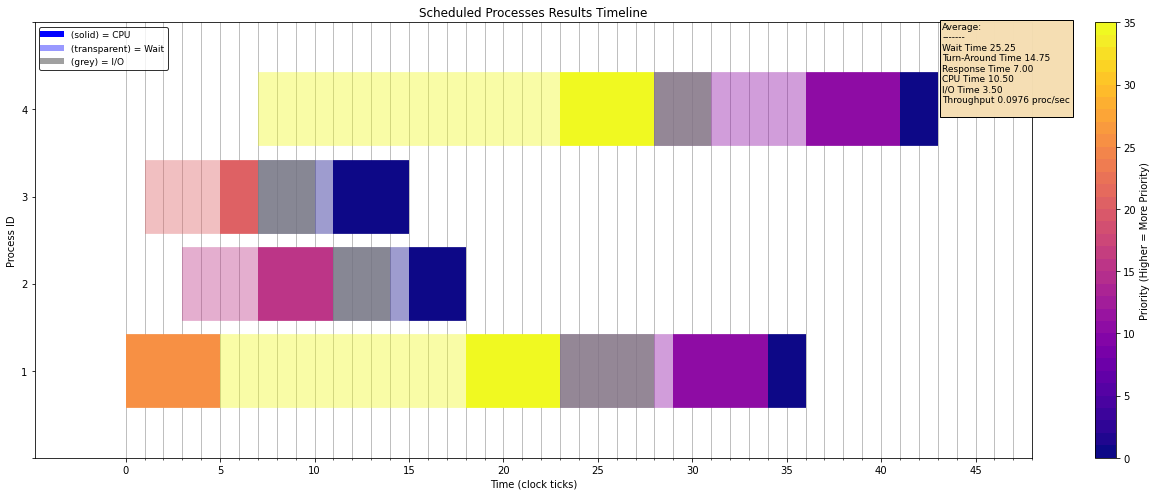

In [37]:
# Plotting the Results Enhanced
operating_system.plotKernalResults(cfs_results_all,
                      "Completely Fair Scheduling Test Results Timeline")


Here we can see that completely fair scheduling does occur based on the
vruntime of the process (In the plot priority level is matching the vruntime)


<br>

---
## Simulations:

Now I will run simulations with a 50/50 split of CPU and I/O bound processes
to compare the general statistics such as the average turnaround time,
response time, wait time, and throughput of the following 5 scheduling
algorithms:

    - Round Robin with quantum of 2
    - Round Robin with quantum of 10
    - Shortest Remaining Time
    - Multilevel Feedback Queue (RR2 => RR 10 => FCFS)
    - Completly Fair Scheduling




Below I will run these simulations:

##### Setting up Process:

In [38]:
sim_procs1 = operating_system.generate_processes(n = 1000,seed=1)
sim_procs2 = copy.deepcopy(sim_procs1)
sim_procs3 = copy.deepcopy(sim_procs1)
sim_procs4 = copy.deepcopy(sim_procs1)
sim_procs5 = copy.deepcopy(sim_procs1)

#### Completely Fair Scheduling:

In [39]:
# Run the kernel with CFS and processes
operating_system.kernal(scheduler.CFS_scheduler, processes=sim_procs5,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from CFS
cfs_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_CFS_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(cfs_sim_results, title = "Completely "
                                                                "Fair "
                                                                "Scheduling "
                                                                "Sim")

# printing the results based on type
operating_system.printKernalResultStatsProcTypes(cfs_sim_results,
                                                     title="Completely "
                                                                   "Fair "
                                                                   "Scheduling "
                                                                   "Sim")

Average Completely Fair Scheduling Sim Stats (All Processes):
-------
Wait Time 789.32
Turn-Around Time 777.49
Response Time 396.41
CPU Time 11.83
I/O Time 6.01
Throughput 0.0833 proc/sec


Average Completely Fair Scheduling Sim Stats (By Process Type):
-------
I/O Process type (506 Processes):
	Wait Time 22.15
	Turn-Around Time 18.19
	Response Time 5.22
	CPU Time 3.96
	I/O Time 6.01
	Throughput 0.0507 proc/sec

CPU Process type (494 Processes):
	Wait Time 1575.12
	Turn-Around Time 1555.23
	Response Time 797.11
	CPU Time 19.88
	I/O Time 6.01
	Throughput 0.0412 proc/sec



#### Simulation observations:

From running CFS with an about 50/50 split of CPU and I/O bound processes
there are a few observations about this implementation of Completely Fair
Scheduling that I can make


#### Round Robin with quantum of 2:

In [40]:
# Run the kernel with RR2 and processes
operating_system.kernal(scheduler.RR_scheduler,quantum=2, processes=sim_procs1,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from RR2
rr_q2_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_RR_Q2_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(rr_q2_sim_results, title = "Round Robin Q2 Sim")
operating_system.printKernalResultStatsProcTypes(rr_q2_sim_results, title = "Round "
                                                                    "Robin Q2 Sim")

Average Round Robin Q2 Sim Stats (All Processes):
-------
Wait Time 1493.33
Turn-Around Time 1481.50
Response Time 113.00
CPU Time 11.83
I/O Time 6.01
Throughput 0.0833 proc/sec


Average Round Robin Q2 Sim Stats (By Process Type):
-------
I/O Process type (506 Processes):
	Wait Time 544.10
	Turn-Around Time 540.14
	Response Time 114.58
	CPU Time 3.96
	I/O Time 6.01
	Throughput 0.0451 proc/sec

CPU Process type (494 Processes):
	Wait Time 2465.61
	Turn-Around Time 2445.73
	Response Time 111.38
	CPU Time 19.88
	I/O Time 6.01
	Throughput 0.0412 proc/sec



#### Round Robin with quantum of 10:

In [41]:
# Run the kernel with RR10 and processes
operating_system.kernal(scheduler.RR_scheduler,quantum=10, processes=sim_procs2,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from RR10
rr_q10_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_RR_Q10_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(rr_q10_sim_results, title = "Round Robin Q10 Sim")
operating_system.printKernalResultStatsProcTypes(rr_q10_sim_results, title = "Round "
                                                                     "Robin Q10 Sim")


Average Round Robin Q10 Sim Stats (All Processes):
-------
Wait Time 1838.41
Turn-Around Time 1826.59
Response Time 381.82
CPU Time 11.83
I/O Time 6.01
Throughput 0.0833 proc/sec


Average Round Robin Q10 Sim Stats (By Process Type):
-------
I/O Process type (506 Processes):
	Wait Time 1410.54
	Turn-Around Time 1406.58
	Response Time 381.73
	CPU Time 3.96
	I/O Time 6.01
	Throughput 0.0439 proc/sec

CPU Process type (494 Processes):
	Wait Time 2276.69
	Turn-Around Time 2256.80
	Response Time 381.91
	CPU Time 19.88
	I/O Time 6.01
	Throughput 0.0412 proc/sec



#### Shortest Remaining Time:

In [42]:
# Run the kernel with SRT and processes
operating_system.kernal(scheduler.SRT_scheduler, processes=sim_procs3,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from SRT
srt_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_SRT_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(srt_sim_results, title = "SRT Sim")
operating_system.printKernalResultStatsProcTypes(srt_sim_results, title = "SRT Sim")


Average SRT Sim Stats (All Processes):
-------
Wait Time 797.06
Turn-Around Time 785.24
Response Time 381.55
CPU Time 11.83
I/O Time 6.01
Throughput 0.0834 proc/sec


Average SRT Sim Stats (By Process Type):
-------
I/O Process type (506 Processes):
	Wait Time 15.42
	Turn-Around Time 11.46
	Response Time 1.59
	CPU Time 3.96
	I/O Time 6.01
	Throughput 0.0508 proc/sec

CPU Process type (494 Processes):
	Wait Time 1597.70
	Turn-Around Time 1577.81
	Response Time 770.73
	CPU Time 19.88
	I/O Time 6.01
	Throughput 0.0412 proc/sec



#### Multilevel Feedback Queue (RR2 => RR 10 => FCFS):

In [43]:
# Run the kernel with MLFQ and processes
operating_system.kernal(scheduler.MLFQ_scheduler, processes=sim_procs4,
                        quantum= 2, quantum2= 10,
                            file_proc_name="2_10_sim", debug=False)

# Importing the CPU results from MLFQ
mlfq_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_MLFQ_2_10_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(mlfq_sim_results, title = "MLFQ_2_10 Sim")
operating_system.printKernalResultStatsProcTypes(mlfq_sim_results, title = "MLFQ_2_10"
                                                                   " Sim")


Average MLFQ_2_10 Sim Stats (All Processes):
-------
Wait Time 2438.64
Turn-Around Time 2426.81
Response Time 4.58
CPU Time 11.83
I/O Time 6.01
Throughput 0.0833 proc/sec


Average MLFQ_2_10 Sim Stats (By Process Type):
-------
I/O Process type (506 Processes):
	Wait Time 1212.08
	Turn-Around Time 1208.12
	Response Time 4.57
	CPU Time 3.96
	I/O Time 6.01
	Throughput 0.0432 proc/sec

CPU Process type (494 Processes):
	Wait Time 3694.99
	Turn-Around Time 3675.11
	Response Time 4.60
	CPU Time 19.88
	I/O Time 6.01
	Throughput 0.0412 proc/sec



#### Comparison observations (Extension):

From running




<br>

---

## References and Acnowlagements

On this project I received help and knowledge from :
   - [Prof. Al Madi](https://www.cs.colby.edu/nsalmadi/)
   - [Prof. Al Madi CFS notes](https://moodle.colby.edu/pluginfile.php/574608/mod_resource/content/1/6-%20Completely%20Fair%20Scheduler.pdf)
   - [Matplotlib event plot documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.eventplot.html)
   - [General Matplotlib Docs](https://matplotlib.org/)
   - [Project Details](https://github.com/mattjax16/CS337-Operating-Systems/blob/master/Projects/Proj2/Project%202_%20Preemptive%20CPU%20Scheduling.pdf)
   - [Wiki on RB Trees](https://en.wikipedia.org/wiki/Red%E2%80%93black_tree)



